In [1]:
import sys
from pathlib import Path as Path
sys.path.insert(0, (Path.home()/'repos/peepholelib').as_posix())

# python stuff
from time import time
from functools import partial
from matplotlib import pyplot as plt
import numpy as np

# torch stuff
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet as IN1K
from torchvision.models import vgg16
from cuda_selector import auto_cuda
from torchvision import transforms

import torchattacks

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
ds_path = '/srv/newpenny/dataset/ImageNet_torchvision'
dataset = 'ImageNet'
seed = 29
verbose = True 

In [4]:
vgg16_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225]))
])

In [5]:
ds = IN1K(root = ds_path,
        split = 'train',
        transform=vgg16_imagenet
        ) 

In [6]:
ds[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

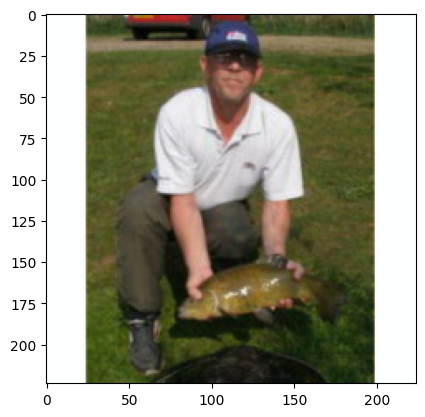

In [8]:
image = ds[0][0]
img = image.detach().cpu().numpy().transpose(1,2,0)
# image = ds[0][0].unsqueeze(dim=0)
labels = torch.tensor(ds[0][1]).unsqueeze(dim=0)
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img = np.clip(img, 0, 1)
plt.imshow(img)

In [9]:
image = torch.from_numpy(img.transpose(2,0,1)).float().unsqueeze(dim=0)
image.shape

torch.Size([1, 3, 224, 224])

In [10]:
nn = vgg16(weights='IMAGENET1K_V1').to(device)

In [11]:
attack = torchattacks.AutoAttack(nn, norm='Linf', eps=8/255, version='standard', n_classes=1000, seed=None, verbose=False)

In [12]:
adv_images = attack(image, labels)
nn(adv_images).argmax(), nn(image.to(device)).argmax()

(tensor(981, device='cuda:0'), tensor(0, device='cuda:0'))

In [13]:
print(f'{torch.norm(adv_images-image.to(device), p=float('inf')).detach().cpu().numpy()}:.4f')

0.0:.4f


In [14]:
adv_images.shape

torch.Size([1, 3, 224, 224])

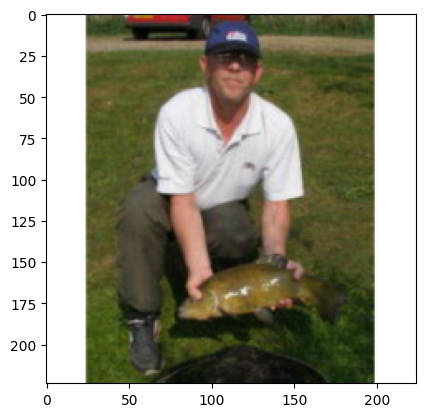

In [15]:
plt.imshow(adv_images[0].detach().cpu().numpy().transpose(1,2,0))

In [18]:
img, adv_images[0]

(array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.]

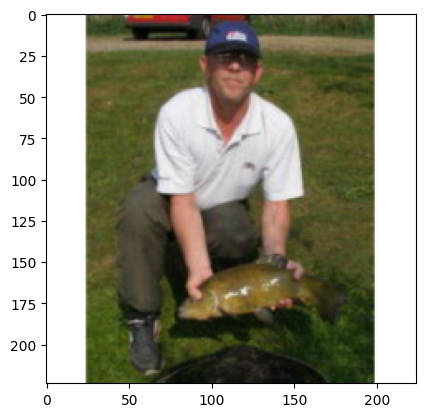

In [18]:
plt.imshow(adv_images[0].detach().cpu().numpy().transpose(1,2,0))